## SNR and CRN (w/out GT)

Import the GT binary mask.

In [1]:
import numpy as np

binary_mask_path = '../data/id_volumes_pw/gt.npy'
binary_mask = np.load(binary_mask_path)
print(f'binary mask loaded with shape {binary_mask.shape}')
print(f'unique values', np.unique(binary_mask))

binary mask loaded with shape (256, 160, 160)
unique values [False  True]


Import the volume to test, change shape, crop it to 256x160x160.

In [81]:
test_path = '../data/id_volumes/id_34.npy'
volume = np.load(test_path)
print(f'test volume loaded with shape {volume.shape}')

test volume loaded with shape (256, 256, 256)


In [82]:
# Swap axes
volume = np.swapaxes(volume, 0, 1)
volume = np.swapaxes(volume, 0, 2) # shape: (256, 256, 256)

# Invert projections
volume = volume[::-1, :, :]

# Rotate counterclockwise 90 degrees
volume = np.rot90(volume, k=1, axes=(1, 2))

# Flip along vertical axis
volume = volume[:, :, ::-1]

In [83]:
center = [dim // 2 for dim in volume.shape] # center coordinates
center

[128, 128, 128]

In [84]:
radius = 128
angle = np.pi/4
margin = 10

side = 2 * radius * np.cos(angle)

offset_depth = 128
offset_height = int(side / 2)
offset_width = int(side / 2)

cropped_volume = volume[
    center[0] - offset_depth: center[0] + offset_depth,
    center[1] - offset_height + margin: center[1] + offset_height - margin,
    center[2] - offset_width + margin: center[2] + offset_width - margin,
]
cropped_volume.shape

(256, 160, 160)

Implement now metrics such as SNR and CNR.

In [85]:
def compute_snr_cnr(test_volume, gt_volume):
    """
    Compute SNR and CNR for a given test volume and binary ground-truth volume.

    Parameters:
        test_volume (numpy.ndarray): 3D numpy array representing the test volume.
        gt_volume (numpy.ndarray): 3D binary numpy array (1 for foreground, 0 for background).

    Returns:
        snr (float): Signal-to-Noise Ratio.
        cnr (float): Contrast-to-Noise Ratio.
    """

    # Check dimensions
    if gt_volume.shape != test_volume.shape:
        raise Exception('Error: test volume and ground truth must have same dimensions.')

    # Extract the foreground and background regions based on gt_volume
    foreground = test_volume[gt_volume == True]
    background = test_volume[gt_volume == False]

    # Compute the mean of the foreground (signal)
    mu_i = np.mean(foreground)

    # Compute the mean and standard deviation of the background (noise)
    mu_b = np.mean(background)
    sigma_b = np.std(background)

    # Compute SNR (Signal-to-Noise Ratio)
    if sigma_b == 0:
        snr = np.inf  # Handle division by zero case
    else:
        snr = 20 * np.log10(mu_i / sigma_b)

    # Compute CNR (Contrast-to-Noise Ratio)
    if sigma_b == 0:
        cnr = np.inf  # Handle division by zero case
    else:
        cnr = 20 * np.log10(np.abs(mu_i - mu_b) / sigma_b)

    return {
        'snr': snr,
        'cnr': cnr
    }

In [86]:
compute_snr_cnr(cropped_volume, binary_mask)

{'snr': 18.114553689956665, 'cnr': 12.518887519836426}

OLD -- Experiment 1

In [16]:
experiment_dir = '../data/battery/4_battery_clean_crops/'

In [21]:
exp_1_names = [
    'exp_1/saxnerf/volume_180.npy',
    'exp_1/saxnerf/volume_90.npy',
    'exp_1/saxnerf/volume_45.npy',
    'exp_1/r2gaus/volume_180.npy',
    'exp_1/r2gaus/volume_90.npy',
    'exp_1/r2gaus/volume_45.npy'
]

exp_2_names = [
    'exp_2/saxnerf/volume_30_150.npy',
    'exp_2/saxnerf/volume_45_135.npy',
    'exp_2/saxnerf/volume_60_120.npy',
    'exp_2/r2gaus/volume_30_150.npy',
    'exp_2/r2gaus/volume_45_135.npy',
    'exp_2/r2gaus/volume_60_120.npy',
]

# Set here the volumes you want to test
volume_names = exp_2_names

test_volumes = []
for volume_name in volume_names:
    volume = np.load(experiment_dir + volume_name)
    test_volumes.append(volume)

print(f'{len(test_volumes)} volumes loaded.')

6 volumes loaded.


In [22]:
for id in range(len(volume_names)):
    snr, cnr = compute_snr_cnr(test_volumes[id], gt_volume)
    print(f'+------- {volume_names[id]} -------+')
    print(f"SNR: {snr:.2f} dB")
    print(f"CNR: {cnr:.2f} dB")
    print()

+------- exp_2/saxnerf/volume_30_150.npy -------+
SNR: 16.59 dB
CNR: 10.57 dB

+------- exp_2/saxnerf/volume_45_135.npy -------+
SNR: 16.44 dB
CNR: 9.69 dB

+------- exp_2/saxnerf/volume_60_120.npy -------+
SNR: 13.94 dB
CNR: 7.04 dB

+------- exp_2/r2gaus/volume_30_150.npy -------+
SNR: 9.04 dB
CNR: 1.68 dB

+------- exp_2/r2gaus/volume_45_135.npy -------+
SNR: 10.75 dB
CNR: 3.77 dB

+------- exp_2/r2gaus/volume_60_120.npy -------+
SNR: 8.42 dB
CNR: -0.82 dB



These are custom video-style metrics but we are lacking reference papers. 

In [1]:
import numpy as np
from skimage.metrics import structural_similarity as ssim

def frame_to_frame_difference(volume):
    """Compute the mean absolute difference between consecutive frames."""
    diffs = [np.abs(volume[i] - volume[i + 1]).mean() for i in range(len(volume) - 1)]
    return np.mean(diffs)

def frame_to_frame_mse(volume):
    """Compute the mean squared error between consecutive frames."""
    mses = [np.mean((volume[i] - volume[i + 1])**2) for i in range(len(volume) - 1)]
    return np.mean(mses)

def frame_to_frame_ssim(volume):
    """Compute the average SSIM between consecutive frames."""
    ssims = [
        ssim(volume[i], volume[i + 1], data_range=volume[i + 1].max() - volume[i + 1].min())
        for i in range(len(volume) - 1)
    ]
    return np.mean(ssims)

def total_variation_time(volume):
    """Compute the total variation across consecutive frames."""
    tv = np.sum([np.abs(volume[i] - volume[i + 1]).sum() for i in range(len(volume) - 1)])
    return tv


In [3]:
# Example usage with a 3D numpy volume
path = '/home/dlboxadmin/Desktop/code-box/exploration/data/battery/4_battery_clean_crops/exp_3/r2gaus/50_random_projs.npy'

volume = np.load(path)  # Replace this with your actual reconstructed volume

print("Frame-to-Frame Difference:", frame_to_frame_difference(volume))
print("Frame-to-Frame MSE:", frame_to_frame_mse(volume))
print("Frame-to-Frame SSIM:", frame_to_frame_ssim(volume))
print("Total Variation in Time:", total_variation_time(volume))


Frame-to-Frame Difference: 0.009967527
Frame-to-Frame MSE: 0.0003783156
Frame-to-Frame SSIM: 0.936653716523297
Total Variation in Time: 166574.12


## PSNR and SSIM (with GT)

In [1]:
import numpy as np
import torch
from skimage.metrics import peak_signal_noise_ratio
from skimage.metrics import structural_similarity as ssim

def compute_psnr(prediction, reference):
    """
    Computes the Peak Signal-to-Noise Ratio (PSNR) between two 3D volumes.
    
    :param prediction: NumPy array representing the predicted volume.
    :param reference: NumPy array representing the reference (ground truth) volume.
    :return: PSNR value in dB.
    """
    return peak_signal_noise_ratio(reference, prediction, data_range=reference.max() - reference.min())

import numpy as np
import torch
from skimage.metrics import structural_similarity as ssim

def compute_ssim(arr1, arr2, size_average=True):
    """
    Compute 3D SSIM by averaging SSIM along depth, height, and width dimensions.

    :param arr1: [NDHW] NumPy array or PyTorch tensor (normalized between 0 and 1).
    :param arr2: [NDHW] NumPy array or PyTorch tensor.
    :param size_average: If True, return the mean SSIM across all batches, else return per-batch SSIM.
    :return: Scalar SSIM value or array of SSIM values per batch.
    """
    # Convert PyTorch tensors to NumPy if necessary
    if torch.is_tensor(arr1):
        arr1 = arr1.cpu().detach().numpy()
    if torch.is_tensor(arr2):
        arr2 = arr2.cpu().detach().numpy()

    assert arr1.shape == arr2.shape, "Input arrays must have the same shape!"
    arr1 = arr1.astype(np.float64)
    arr2 = arr2.astype(np.float64)

    # Add batch dimension
    arr1 = arr1[np.newaxis, ...]
    arr2= arr2[np.newaxis, ...]

    # Compute data_range dynamically
    data_range = arr1.max() - arr1.min()

    N = arr1.shape[0]

    # Compute SSIM along Depth (D)
    arr1_d = np.transpose(arr1, (0, 2, 3, 1))
    arr2_d = np.transpose(arr2, (0, 2, 3, 1))
    ssim_d = [ssim(arr1_d[i], arr2_d[i], data_range=data_range) for i in range(N)]
    
    # Compute SSIM along Height (H)
    arr1_h = np.transpose(arr1, (0, 1, 3, 2))
    arr2_h = np.transpose(arr2, (0, 1, 3, 2))
    ssim_h = [ssim(arr1_h[i], arr2_h[i], data_range=data_range) for i in range(N)]
    
    # Compute SSIM along Width (W)
    ssim_w = [ssim(arr1[i], arr2[i], data_range=data_range) for i in range(N)]

    # Convert lists to NumPy arrays
    ssim_d = np.asarray(ssim_d, dtype=np.float64)
    ssim_h = np.asarray(ssim_h, dtype=np.float64)
    ssim_w = np.asarray(ssim_w, dtype=np.float64)

    # Compute final SSIM as the mean of three orientations
    ssim_avg = (ssim_d + ssim_h + ssim_w) / 3

    return ssim_avg.mean() if size_average else ssim_avg



We need to have the fbp gt volume aligned with the predicted volume.

In [2]:
#volume_gt = np.load('../data/z-volumes/fbp/fbp_crop_enh_seg.npy')
volume_gt = np.load('../data/volume_distrib/battery/fbp_enh.npy')
volume_gt.shape

(256, 256, 256)

In [3]:
volume_gt.min(), volume_gt.max()

(0.0, 1.0)

In [4]:
#volume_pred = np.load('../data/id_volumes/id_22_crop_enh.npy')
volume_pred = np.load('../data/volume_distrib/image_pred.npy')
volume_pred.shape

(256, 256, 256)

In [5]:
volume_pred.min(), volume_pred.max()

(0.9999993, 0.9999994)

In [6]:
# already normalized?
def normalize_volume(volume):
    return (volume - np.min(volume)) / (np.max(volume) - np.min(volume))

volume_pred = normalize_volume(volume_pred)
volume_pred.min(), volume_pred.max()

(0.0, 1.0)

Make R2gaussian volume comparable with FBP volume (we can compare the slices side by side).

In [15]:
# Swap axes (do you need it? check volumes in napari first)
'''
volume_pred = np.swapaxes(volume_pred, 0, 1)
volume_pred = np.swapaxes(volume_pred, 0, 2) # shape: (256, 256, 256)

# Invert projections
volume_pred = volume_pred[::-1, :, :]

# Rotate counterclockwise 90 degrees
volume_pred = np.rot90(volume_pred, k=1, axes=(1, 2))

# Flip along vertical axis
volume_pred = volume_pred[:, :, ::-1]
'''

Check check if volumes are aligned

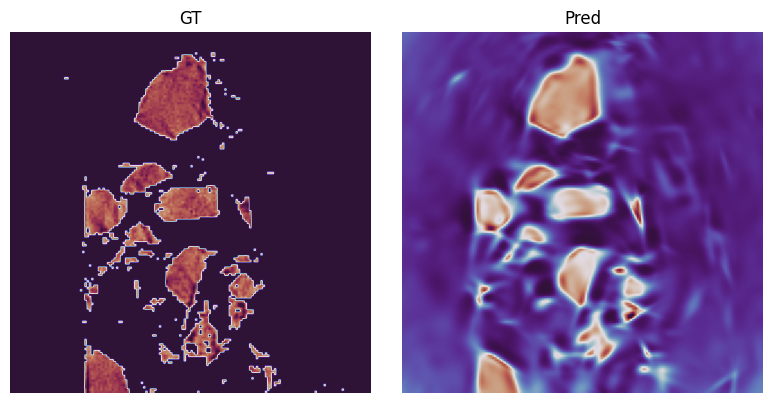

In [29]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

id = np.random.randint(256)
axes[0].imshow(volume_gt[id,:,:], cmap='twilight_shifted')
axes[0].set_title("GT")
axes[0].axis("off")

axes[1].imshow(volume_pred[id,:,:], cmap='twilight_shifted')
axes[1].set_title("Pred")
axes[1].axis("off")

plt.tight_layout()
plt.show()

In [6]:
# project work
#volume_gt = np.load('../data/z-bin/chest/image_gt.npy')
#volume_pred = np.load('../data/z-bin/chest/exp_1/method_2/image_pred_exp.npy')


# fbp gt data volume (already loaded above)
#volume_gt = np.load('../data/z-bin/chest/image_gt.npy')
#volume_pred = np.load('../data/z-bin/chest/exp_2/label_a/image_pred.npy')

psnr_value = compute_psnr(volume_pred, volume_gt)
ssim_value = compute_ssim(volume_pred, volume_gt)

print(f"PSNR: {psnr_value:.2f} dB")
print(f"SSIM: {ssim_value:.4f}")


PSNR: 4.14 dB
SSIM: 0.0942
